In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reviews = pd.read_csv('data/tripadvisor_hotel_reviews.csv')

In [3]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
#distribution of ratings
ratings_distribution = reviews[['Rating']].value_counts()
print(ratings_distribution)

Rating
5         9054
4         6039
3         2184
2         1793
1         1421
dtype: int64


### Exploratory Data Analysis

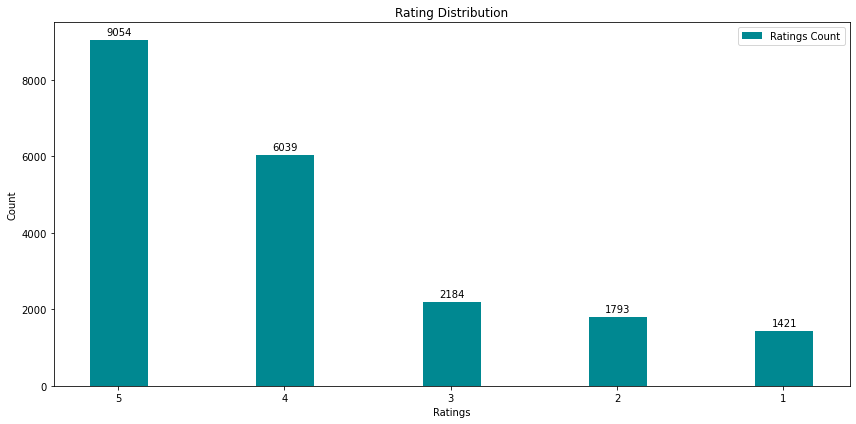

In [6]:
#plot of distribution of ratings
labels = ratings_distribution.index.get_level_values(0).values
distribution = ratings_distribution.values

x = np.arange(len(labels))
width = 0.35


fig, ax = plt.subplots(figsize=(12,6))
rect = ax.bar(x-width/2, distribution, width, label='Ratings Count', color='#008891')

# Add text for labels, title and custom x-axis tick labels
ax.set_ylabel('Count')
ax.set_xlabel('Ratings')
ax.set_title('Rating Distribution')
ax.set_xticks(x-0.18)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rect)
fig.savefig('plots/Ratings-Distribution.png', facecolor='w')
fig.tight_layout()
plt.show()

---------------
### Discretize the ratings variable into bins to adjust the imbalanced class distribution issue  

### Pre-processing Reviews
----------------

In [7]:
regex = 'https|<|>|=|;|:|\'|!|@|\/|#|$|%|\^|&|\*|\[|\]|\.|-|_|\d+|\+|\?|Û|¢|\(|\)|\||,'

In [8]:
def discretize(rating):
    """
    This function takes in a rating and based on the following scheme
    it puts it into 3 bins:
    1-2-3: Needs Improvement
    4: Good
    5: Amazing
    """
    if rating<=3:
        rating='Needs Improvement'
    elif rating==4:
        rating='Good'
    elif rating==5:
        rating='Amazing'
    return rating


def remove_patterns(review, regex='\d+'):
    """
    Given a review remove patterns which are unnecessary and do not add meaning to the review.
    """
    review = re.sub(regex, ' ', str(review))
    review = re.sub(' +', ' ', str(review))
    review = review.lstrip().rstrip()

    review = review.lower()

    return review


def clean_data(dataframe, cols=['Review', 'Rating']):
    """
    Take in the dataframe remove unneded patterns by applying remove_patterns on the review column and return the dataframe.
    """
    dataframe_2 = dataframe.copy()
    
    for col in cols:
        if col == 'Review':
            dataframe_2[col] = dataframe_2[col].apply(remove_patterns, regex=regex)
        if col == 'Rating':
            dataframe_2[col] = dataframe_2[col].apply(discretize)
    
    return dataframe_2

In [9]:
reviews = clean_data(reviews)

### Plot of class distribution after discretization

In [10]:
discrete_ratings_distribution = reviews[['Rating']].value_counts()

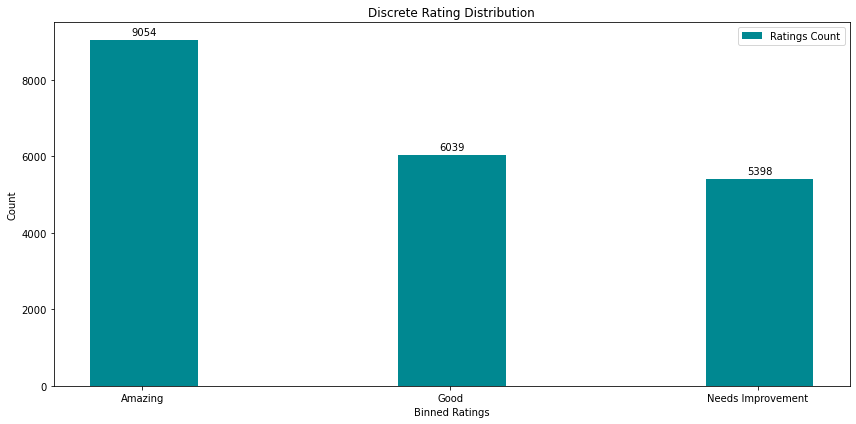

In [11]:
#plot of distribution of ratings
labels = discrete_ratings_distribution.index.get_level_values(0).values
distribution = discrete_ratings_distribution.values

x = np.arange(len(labels))
width = 0.35


fig, ax = plt.subplots(figsize=(12,6))
rect = ax.bar(x-width/2, distribution, width, label='Ratings Count', color='#008891')

# Add text for labels, title and custom x-axis tick labels
ax.set_ylabel('Count')
ax.set_xlabel('Binned Ratings')
ax.set_title('Discrete Rating Distribution')
ax.set_xticks(x-0.18)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rect)
fig.savefig('plots/Binned-Ratings-Distribution.png', facecolor='w')
fig.tight_layout()
plt.show()

In [12]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Needs Improvement
2,nice rooms not experience hotel monaco seattle...,Needs Improvement
3,unique great stay wonderful time hotel monaco ...,Amazing
4,great stay great stay went seahawk game awesom...,Amazing


### Feature Engineering

In [13]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [14]:
def process_reviews(review):
    stopwords_english = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
#     stemmer = PorterStemmer()
#     snowball_stemmer = nltk.stem.SnowballStemmer('english')
    
    tokens = word_tokenize(review.lower())
    clean_review = []
    for word in tokens:
        if (word not in stopwords_english and 
           word not in string.punctuation):
            lemmatized_word = lemmatizer.lemmatize(word)            
#             stemmed_word = stemmer.stem(word)
            clean_review.append(lemmatized_word)
    return ' '.join(clean_review)

In [15]:
reviews['Review'] = reviews['Review'].apply(process_reviews)

In [16]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Needs Improvement
2,nice room experience hotel monaco seattle good...,Needs Improvement
3,unique great stay wonderful time hotel monaco ...,Amazing
4,great stay great stay went seahawk game awesom...,Amazing


In [17]:
import joblib
import random
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import LabelEncoder

- uncomment when training a new vectorizer

In [18]:
# vectorizer = TfidfVectorizer()
# vectorizer_model = vectorizer.fit(reviews['Review'])

In [19]:
#save the vectorizer
# joblib.dump(vectorizer_model, 'saved_models/vectorizer.pkl')

In [86]:
def get_xy(dataframe, vectorizer='saved_models/vectorizer.pkl', label_encoder='saved_models/rating_encoder.pkl'):
    """
    Vectorize Review 
    Label Encode Ratings
    Get dependent and independent variables.
    """
    #encode ratings
#     encoder = LabelEncoder()
#     encoder.fit(dataframe['Rating'])
#     joblib.dump(encoder, label_encoder)
    
    encoder = joblib.load(label_encoder)
    dataframe['Rating'] = encoder.transform(dataframe['Rating'])
    
    #vectorize reviews
    vectorizer = joblib.load(vectorizer)
    vectorizer_transform = vectorizer.transform(dataframe['Review'])
    
    features = vectorizer.get_feature_names()
    print('Total number of features after vectorizing: {}'.format(len(features)))
    
    #create a dataframe of vectorized reviews
    vectorized_reviews = pd.DataFrame(data = vectorizer_transform.toarray(), index=dataframe.index, columns=vectorizer.get_feature_names())
    
    if len(features)>25000:
        #select a random subset of defined features
        random.seed(10)
        feature_subset = random.sample(range(0, len(vectorizer.get_feature_names())), 25000)    
        x = vectorized_reviews.iloc[:, feature_subset]
        y = dataframe['Rating']
    else:
        x = vectorized_reviews
        y = dataframe['Rating']
    
    return x, y

In [87]:
x, y = get_xy(reviews)

Total number of features after vectorizing: 44842


### Feature Selection

In [29]:
# import sklearn
# nltk.__version__

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

In [38]:
def split_data(x, y, test_size=0.25, random_state=123):
    """
    Create train test splits.
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size=0.25,
                                                   random_state=123)
    return x_train, x_test, y_train, y_test

In [100]:
x_train, x_test, y_train, y_test = split_data(x, y, test_size=0.25, random_state=123)

### Variance Threshold Feature Selection

In [101]:
# vt_selector = VarianceThreshold(threshold=(0.90*(1-0.90)))
# vt_selector.fit(round(x))
# # vt_selected_features = vt_selector.transform(x)
# x_vt_select = x[vt_selector.get_support()]

### SVC Feature Selection

In [46]:
def train_feature_selector(x_train, x_test, y_train, y_test, model_path='saved_models/feature_selector.pkl'):
    """Train the feature selector and save the model"""
    slacks = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,6,7,8,9]
    
    score = dict()
    for slack in slacks:
        svm = LinearSVC(C=slack, random_state=0, penalty='l1', dual=False, multi_class='ovr')
        svm_fit = svm.fit(x_train, y_train)

        svm_predict = svm_fit.predict(x_test)

        score[slack] = accuracy_score(y_test, svm_predict)
    
    fig, ax = plt.subplots(figsize=(12,5))
    ax = plt.plot(slacks, [score for score in score.values()])
    plt.ylabel('Accuracy Score')
    plt.xlabel('Slack - C')
    plt.show()
    fig.savefig('plots/SVC_FeatureSelection.png')
    
    #retrain the model based on the slack that produces the highest accuracy score on the test set
    selected_slack = max(score, key=score.get)
    svm = LinearSVC(C=selected_slack, random_state=0, penalty='l1', dual=False, multi_class='ovr').fit(x_train, y_train)
    feature_selection_model = SelectFromModel(svm, prefit=True)
    
    #save the model
    joblib.dump(feature_selection_model, model_path)
    
    #print the slack with the highest test accuracy
    print('Slack with the highest test accuracy: {}'.format(max(score, key=score.get)))

- Run the cell below only when you train a new feature selector

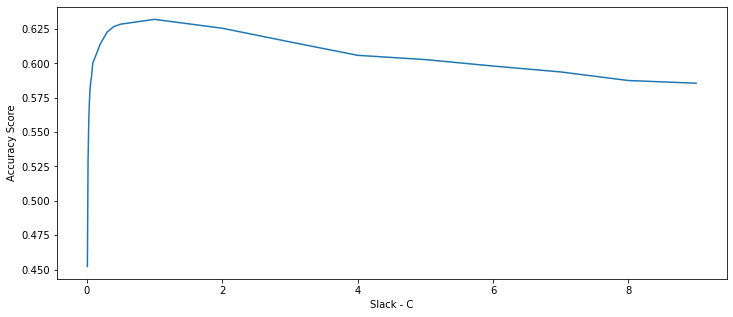

Slack with the highest test accuracy: 1


In [47]:
train_feature_selector(x_train, x_test, y_train, y_test, model_path='saved_models/feature_selector.pkl')

In [51]:
def feature_selection_svc(x_train, x_test, model_path='saved_models/feature_selector.pkl'):
    """This function selects features based on a LinearSVC"""    
    #load the feature selection model
    feature_selection_model = joblib.load(model_path)
    
    #get selected features
    feature_set = x_train.columns[feature_selection_model.get_support()]
    
    print('Total Features: {}'.format(len(x_train.columns)))
    print('Selected Features: {}'.format(len(feature_set)))
    print('Removed Features: {}'.format(len(x_train.columns)-len(feature_set)))
    
    #select features in x_train and x_test
    x_train = x_train[feature_set]
    x_test = x_test[feature_set]
    
    return feature_set, x_train, x_test

In [57]:
feature_set, x_train, x_test = feature_selection_svc(x_train, x_test, model_path='saved_models/feature_selector.pkl')

Total Features: 15000
Selected Features: 2304
Removed Features: 12696


### Models

In [84]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [75]:
accuracy = {}
for depth in range(6,15):
    model = GradientBoostingClassifier(max_depth=depth, random_state=10, max_features=round(len(feature_set)*0.10))
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    accuracy[depth] = accuracy_score(y_pred, y_test) 
    print('Depth ',depth,'Accuracy: ',accuracy[depth])

Depth  6 Accuracy:  0.6012102283818075
Depth  7 Accuracy:  0.5976966621120438
Depth  8 Accuracy:  0.6037478040210814
Depth  9 Accuracy:  0.6037478040210814
Depth  10 Accuracy:  0.6070661721647472
Depth  11 Accuracy:  0.6027718133905915
Depth  12 Accuracy:  0.6078469646691391
Depth  13 Accuracy:  0.6035526058949834
Depth  14 Accuracy:  0.6092133515518251


In [78]:
rf_accuracy = {}
for depth in range(10,25):
    rf_model = RandomForestClassifier(max_depth=depth, random_state=10)#, max_features=round(len(feature_set)*0.10))
    rf_model.fit(x_train, y_train)
    
    y_pred = rf_model.predict(x_test)
    
    rf_accuracy[depth] = accuracy_score(y_pred, y_test) 
    print('Depth ',depth,'Accuracy: ',rf_accuracy[depth])

Depth  10 Accuracy:  0.517860628537966
Depth  11 Accuracy:  0.5270349404645716
Depth  12 Accuracy:  0.5305485067343354
Depth  13 Accuracy:  0.5393324224087449
Depth  14 Accuracy:  0.5446027718133906
Depth  15 Accuracy:  0.5471403474526645
Depth  16 Accuracy:  0.5494827249658403
Depth  17 Accuracy:  0.5541674799921921
Depth  18 Accuracy:  0.5590474331446418
Depth  19 Accuracy:  0.5645129806753855
Depth  20 Accuracy:  0.5695881319539332
Depth  21 Accuracy:  0.574077688854187
Depth  22 Accuracy:  0.5766152644934609
Depth  23 Accuracy:  0.574468085106383
Depth  24 Accuracy:  0.5795432363849307


In [102]:
rf_model2 = OneVsRestClassifier(RandomForestClassifier(max_depth=24, random_state=10))
rf_model2.fit(x_train, y_train)
y_pred = rf_model2.predict(x_test)
print('Accuracy: ',accuracy_score(y_pred, y_test))

Accuracy:  0.5660745656841695


In [83]:
logit_model = OneVsRestClassifier(LogisticRegression(random_state=10)).fit(x_train,y_train)
logit_pred = logit_model.predict(x_test)
print('Accuracy: ',accuracy_score(logit_pred,y_test))

Accuracy:  0.6326371266835839


In [85]:
bc_model = OneVsRestClassifier(BaggingClassifier(random_state=10)).fit(x_train,y_train)
bc_pred = bc_model.predict(x_test)
print('Accuracy: ',accuracy_score(bc_pred,y_test))

Accuracy:  0.572906500097599
